# Práctico 1

En este práctico, correspondiente a la primera mitad de la materia, trabajaremos con un dataset extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

## Configuración inicial

In [17]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

### Cargamos el dataset

In [2]:
DATASET_FILE = "dataset/vacunas.csv"

dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}
df = pd.read_csv(DATASET_FILE, dtype=dtypes).dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


### Observamos algunos ejemplos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155123 entries, 0 to 163178
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   created_at             155123 non-null  object
 1   id_str                 155123 non-null  object
 2   full_text              155123 non-null  object
 3   in_reply_to_status_id  151834 non-null  object
 4   in_reply_to_user_id    151949 non-null  object
 5   user.id                155123 non-null  object
 6   user_retweeters        155123 non-null  object
 7   sentiment              1029 non-null    object
dtypes: object(8)
memory usage: 10.7+ MB


In [4]:
len(df)

155123

In [5]:
idx = 0
print('Texto:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Texto: Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".
Retweets: 9


In [6]:
idx = 376
print('Text:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Text: Todo lo que hay que entender sobre la decisión –o no– de poner más vacunas en más brazos (por ejemplo, usar las 1º dosis en muchos y si es necesario retrasar la 2º) está en esta excelente nota de Nora Bär. https://t.co/A0I03DyxgO
Retweets: 48


### Calculamos la cantidad de hilos

In [7]:
roots = df[df['in_reply_to_user_id'].isna()]
roots.shape

(3174, 8)

## Actividades

### **1. Construcción del grafo** 

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

**Opcional:** Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.

In [8]:
users = df["user.id"].unique().tolist()
edges = []
for _, (user_id, retweet_ids) in df[["user.id", "user_retweeters"]].iterrows():
    retweeters = [(user_id, rt) for rt in retweet_ids]
    edges.extend(retweeters)

In [9]:
import networkx as nx

directed_G = nx.DiGraph()
directed_G.add_nodes_from(users)
directed_G.add_edges_from(edges)

print(nx.info(directed_G))

DiGraph with 65934 nodes and 93692 edges


In [10]:
G = nx.Graph()
G.add_nodes_from(users)
G.add_edges_from(edges)

print(nx.info(G))

Graph with 65934 nodes and 93404 edges


Calculamos la componente conexa más grande

In [11]:
largest_cc = max(nx.connected_components(G), key=len)

In [12]:
larg_G = nx.Graph()
larg_G.add_nodes_from(largest_cc)
larg_G.add_edges_from(edges)

print(nx.info(larg_G))

Graph with 39800 nodes and 93404 edges


In [26]:
df_user = pd.DataFrame({'user':list(larg_G.nodes())})

In [27]:
deg_seq = np.array([k for v, k in larg_G.degree()])
df_user['degree'] = deg_seq

In [15]:
degree = [k for v, k in larg_G.degree()]
avg_degree = np.mean(degree)
max_degree = np.max(degree)
assortativity = nx.degree_assortativity_coefficient(larg_G)
transitivity = np.mean(list(nx.clustering(larg_G).values()))
coeficient_clustering = nx.transitivity(larg_G)

In [16]:
print("Degree del grafo:", avg_degree)
print("Max degree del grafo:",max_degree)
print("Assortativity del grafo:", assortativity)
print("Transitivity del grafo:", transitivity)
print("Clustering Coeficient del grafo:", coeficient_clustering)

Degree del grafo: 4.693668341708543
Max degree del grafo: 8207
Assortativity del grafo: -0.22131902542941656
Transitivity del grafo: 0.09990623904532055
Clustering Coeficient del grafo: 0.0016125612488585316


In [17]:
df_user.degree.describe()

count    39800.000000
mean         4.693668
std         69.302786
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8207.000000
Name: degree, dtype: float64

In [18]:
random_G = nx.configuration_model(degree, create_using=nx.Graph)

In [19]:
degree = [k for v, k in random_G.degree()]
avg_degree = np.mean(degree)
max_degree = np.max(degree)
assortativity = nx.degree_assortativity_coefficient(random_G)
transitivity = np.mean(list(nx.clustering(random_G).values()))
coeficient_clustering = nx.transitivity(random_G)

In [20]:
print("Degree del grafo random:", avg_degree)
print("Max degree del grafo random:", max_degree)
print("Assortativity del grafo:", assortativity)
print("Transitivity del grafo:", transitivity)
print("Clustering Coeficient del grafo:", coeficient_clustering)

Degree del grafo random: 4.162311557788945
Max degree del grafo random: 4610
Assortativity del grafo: -0.15006268896838018
Transitivity del grafo: 0.059148569831911905
Clustering Coeficient del grafo: 0.006728582676610571


Observamos que los valores de las métricas obtenidas para el grafo generado aleatoriamente son muy similares a las calculadas para la componenente principal de nuestro grafo. 

### **2. Centralidad**

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades? 

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

**Opcional:** Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.

In [28]:
#betweenness = nx.betweenness_centrality(larg_G)
eigenvector = nx.eigenvector_centrality(larg_G,max_iter=1000)
pagerank = nx.pagerank(larg_G)
clustering_coefficient =  nx.clustering(larg_G)
#closeness = nx.closeness_centrality(larg_G)
#katz = nx.katz_centrality(larg_G)

#df_user['betweenness'] = list(betweenness.values())
df_user['eigenvector'] = list(eigenvector.values())
df_user['pagerank'] = list(pagerank.values())
df_user['Cws'] = list(clustering_coefficient.values())
#df_user['closeness'] = list(closeness.values())
#df_user['katz'] = list(katz.values())

In [34]:
df_user.describe().round(2)

,degree,eigenvector,pagerank,Cws
count,39800.00,39800.00,39800.00,39800.00
mean,4.69,0.00,0.00,0.10
std,69.30,0.00,0.00,0.24
min,1.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00
50%,1.00,0.00,0.00,0.00
75%,3.00,0.00,0.00,0.00
max,8207.00,0.36,0.04,1.00


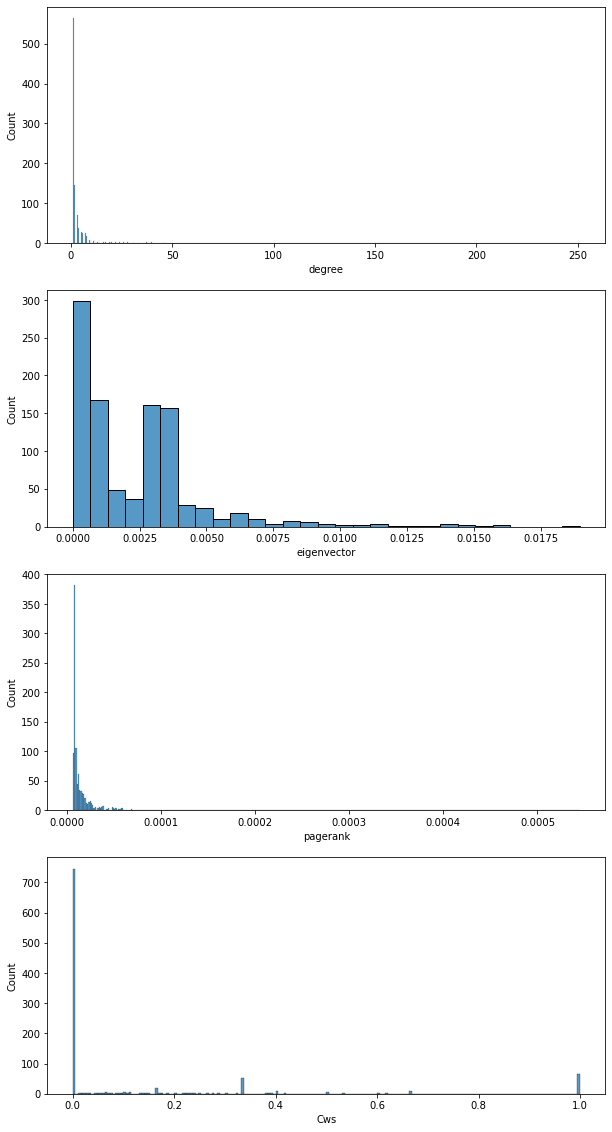

In [36]:
fig, axes = plt.subplots(4,figsize=(10,20))

#'closeness','katz'

columns=['degree','eigenvector','pagerank','Cws']

for ax, col in zip(axes, columns):
    sn.histplot(data=df_user.sample(1000), x=col, ax=ax)
    

In [52]:
data = {}
for col in columns:
    top_users = df_user.nlargest(10, columns=[col])['user'].tolist()
    data[col] = top_users
pd.DataFrame(data)

,degree,eigenvector,pagerank,Cws
0,252168075,130979339,252168075,236694929
1,130979339,73102744,130979339,1250071980784697344
2,73102744,252168075,73102744,1200475594410151936
3,367933714,367933714,593189095,176610516
4,593189095,2687724840,367933714,1283248803575930880
5,2687724840,593189095,2687724840,1157604001304784896
6,931564592328781824,312708081,144929758,4292292021
7,144929758,144929758,931564592328781824,1346144957774647298
8,312708081,931564592328781824,312708081,917945914802745345
9,1077176953,959033548379508736,1077176953,772245551131856896


In [65]:
pd.DataFrame(np.concatenate(list(data.values()))).value_counts()

252168075              3
2687724840             3
931564592328781824     3
73102744               3
593189095              3
130979339              3
367933714              3
144929758              3
312708081              3
1077176953             2
1157604001304784896    1
236694929              1
176610516              1
1346144957774647298    1
4292292021             1
1283248803575930880    1
1250071980784697344    1
772245551131856896     1
917945914802745345     1
1200475594410151936    1
959033548379508736     1
dtype: int64

252168075 , 130979339,  73102744 

### **3. Comunidades**

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada. 

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

**Opcional:** Correr el algoritmo de Louvain con distintas semillas aleatorias. Utilizar alguna métrica de comparación externa entre las particiones obtenidas para determinar en qué medida depende el algoritmo de la condición inicial.